# Quickstart


`AutoEmulate`'s goal is to make it easy to find a good emulator model for your simulation. Here's the basic workflow:

In [1]:
import numpy as np
from autoemulate.compare import AutoEmulate
from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.projectile import simulator

## Experimental design

Before we build an emulator or surrogate model, we need to get a set of input/output pairs from the simulation. This is called the **experimental design** and is currently not a key part of `AutoEmulate`, because this step is tricky to automate. There are lots of sampling techniques, but here we are using Latin Hypercube Sampling.   

Below, `simulator` is a simulation for a projectil motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). It takes two inputs, the drag coefficient (on a log scale) and the velocity and outputs the distance the projectile travelled. We sample 100 sets of inputs `X` using a Latin Hypercube and run the simulator for those inputs to get the outputs `y`.

In [2]:
# sample from a simulation
lhd = LatinHypercube([(-5., 1.), (0., 1000.)])
X = lhd.sample(100)
y = np.array([simulator(x) for x in X])
X.shape, y.shape

((100, 2), (100,))

## Compare emulator models using `AutoEmulate`

With a set of inputs / outputs, we can run `AutoEmulate` in just three lines of code. First, we initialise an `AutoEmulate` object. Then, we run `setup(X, y)`, providing the simulation inputs and outputs. Lastly, `compare()` will fit a range of different models to the data and evaluate them using cross-validation, returning the best emulator.

In [3]:
# compare emulator models
ae = AutoEmulate()
ae.setup(X, y)
best_model = ae.compare()

autoemulate - Cross-validating SecondOrderPolynomial...
autoemulate - Parameters: {'degree': 2}
autoemulate - Cross-validating RBF...
autoemulate - Parameters: {'degree': 1, 'epsilon': 1.0, 'kernel': 'thin_plate_spline', 'smoothing': 0.0}
autoemulate - Cross-validating RandomForest...
autoemulate - Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': False, 'random_state': None}
autoemulate - Cross-validating GradientBoosting...
autoemulate - Parameters: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0}
autoemulate - Cross-validating GaussianProcessSk...
autoemulate - Parameters: {'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': 1.0, 'kerne

## Printing and plotting

We can print the average cross-validation results in tabular form:

In [4]:
ae.print_results()

Average scores across all models:
                   model        r2         rmse
0      GaussianProcessSk  0.997974   297.201563
1                    RBF  0.971615  1019.011240
2           RandomForest  0.878028  2215.195395
3       GradientBoosting  0.808139  2603.277252
4  SupportVectorMachines  0.806707  3082.268749
5  SecondOrderPolynomial  0.689983  3232.877098
6                XGBoost  0.613199  3290.007925
7            NeuralNetSk -0.157063  6995.237158
8         NeuralNetTorch -0.246700  7812.114941


Or create plots comparing the best fitting cv-folds for each model:

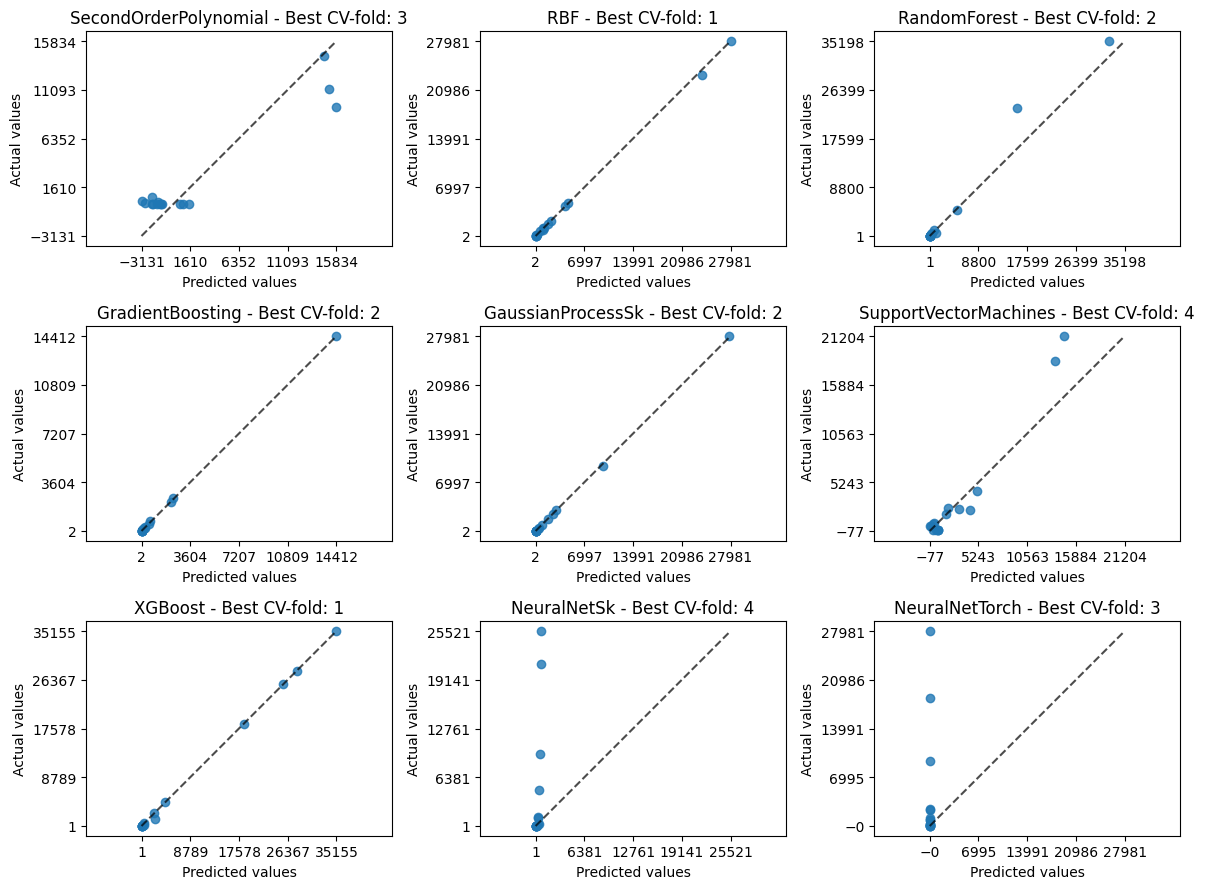

In [5]:
ae.plot_results()

## Evaluating the emulator

Now we can evaluate the best emulator model on the holdout / test set.

In [6]:
ae.evaluate_model(best_model)

,model,rmse,r2
0,GaussianProcessSk,166.194,0.999


And plot the test set predictions.

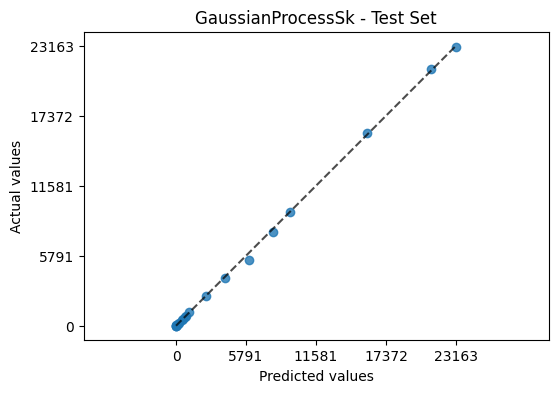

In [7]:
ae.plot_model(best_model)

## Saving models

Lastly, we can save and load the best model. Note: there are some checks that the environment in which the model is loaded is similar to the environment in which it was saved.

Before saving a model, we usually want to retrain it on the full dataset.

In [8]:
# refit best model on full dataset
best_emulator = ae.refit_model(best_model)

# save & load best model
ae.save_model(best_emulator, "best_model")
best_emulator = ae.load_model("best_model")

Lastly, we can use the best model to make predictions for new inputs. 

In [9]:
# emulate
best_emulator.predict(X[:10])

array([2.30912798e+04, 6.71623935e-01, 7.31881524e+00, 2.92554903e+00,
       9.37517512e+03, 2.17208634e+03, 1.11714046e+04, 2.25391029e+03,
       2.79811009e+04, 1.80969447e+00])